# CrowdTruth metrics 2.0 documentation

Let:

* $workers(u):$ all workers that annotate media unit $u$;
* $units(i):$ all input media units annotated by worker $i$;
* $WorkVec(i, u):$ annotations of worker $i$ on media unit $u$ as a binary vector;
* $MediaUnitVec(s) = \sum_{i \in workers(s)} WorkVec(i,s)$, where $s$ is an input media unit.

## Media Unit Quality Score (UQS)

The unit quality score $UQS(u)$ is computed as the average cosine similarity between all worker vectors for a given input media unit $u$, weighted by the worker quality ($WQS$) and annotation quality ($AQS$). The goal is to capture the degree of agreement in annotating the media unit. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score.

$$ UQS(u) = \frac{\sum_{i, j \in workers(u)} Wcos(WorkVec(i,u), WorkVec(j,u)) \; WQS(i) \; WQS(j)}{\sum_{i, j \in workers(u)} WQS(i) \; WQS(j)}, \; i \neq j.$$


### Weighted Cosine

To weigh the metrics with the annotation quality, we compute $Wcos$, the weighted version of the cosine similarity. This metric is only applicable to closed tasks, where annotation quality can be calculated across media units. For open-ended tasks, we consider annotation quality equal to 1 and calculate the regular cosine similarity.

$$ Wcos(vec_1, vec_2) = \frac{\sum_{a} vec_1(a) \; vec_2(a) \; AQS(a)}{\sqrt{(\sum_{a} vec_1^2(a) \; AQS(a)) \; (\sum_{a} vec_2^2(a) \; AQS(a))}} .$$ 


## Worker Quality Score (WQS)

The worker quality score $WQS(i)$ for a given worker $i$ is the product of 2 separate metrics - the worker-worker agreement $WWA(i)$ and the worker-media unit agreement $WUA(i)$.

$$ WQS(i) = WUA(i) \; WWA(i) .$$

### Worker-Media Unit Agreement

The worker-media unit agreement $WUA(i)$ is the average cosine distance between the annotations of a worker $i$ and all annotations for the media units they have worked on, weighted by the media unit and annotation quality. It calculates how much a worker disagrees with the crowd on a media unit basis. Through the weighted average, media units and anntation with lower quality will have less of an impact on the final score.

$$ WSA(i) = \frac{\sum_{u \in units(i)} Wcos(WorkVec(i,u), MediaUnitVec(u) - WorkVec(i, u)) \; UQS(u)}{\sum_{u \in units(i)} UQS(u)} .$$

### Worker-Worker Agreement

The worker-worker agreement $WWA(i)$ is the average cosine distance between the annotations of a worker $i$ and all other workers that have worked on the same media units as worker $i$, weighted by the worker and annotation qualities. The metric gives an indication as to whether there are consisently like-minded workers. This is useful for identifying communities of thought. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score of the given worker.

$$ WWA(i) = \frac{ \sum_{j \in workers(u \in units(i))} Wcos(WorkVec(i, u), WorkVec(j, u)) \; WQS(j) \; UQS(u) }{ \sum_{j \in workers(s \in units(i))} WQS(j) \; UQS(u) }, \; i \neq j .$$


## Annotation Quality Score (AQS)

The annotation quality score $AQS(a)$ calculates the agreement of selecting an annotation $a$, over all the media units it appears in. Therefore, it is only applicable to closed tasks, where the same annotation set is used for all input media units. It is based on $P_a(i | j)$, the probability that if a worker $j$ annotates $a$ in a media unit, worker $i$ will also annotate it. 

$$ P_a(i | j) = \frac{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(i, s)(r) \; WorkVec(j, s)(r) }{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(j, u)(r) } . $$

$AQS(a)$ is the weighted average of $P_a(i | j)$ for all possible pairs of workers. Through the weighted average, input media units and workers with lower quality will have less of an impact on the final score of the annotation.

$$ AQS(a) = \frac{ \sum_{i,j} WQS(i) \; WQS(j) \; P_a(i | j) }{ \sum_{i,j} WQS(i) \; WQS(j) }, i \neq j . $$


## Media Unit-Annotation Score (UAS)

The media unit - annotation score $UAS(u, a)$ calculates the likelihood that annotation $a$ is expressed in input media unit $u$. It is the ratio of the number of workers that picked annotation $u$ over all workers that annotated the unit, weighted by the worker quality.

$$ UAS(u, a) = \frac{ \sum_{i \in workers(u)} WorkVec(i,u)(a) \; WQS(i) }{ \sum_{i \in workers(u)} WQS(i) }. $$

# Prepare the input file(s)

In [28]:
filename = "Bin2-CFFiles/combinedfile.csv"
dataset = pd.read_csv(filename)
nist_labels = pd.read_csv("nist_labels.csv")

rows = []
header = list(dataset)
rows.append(header)

for i in xrange(len(dataset.index)):
    subset = nist_labels[(nist_labels["Topic Id"] == dataset["query_id"].iloc[i]) & (nist_labels["Document Id"] == dataset["document_id"].iloc[i])]
    
    if len(subset) == 1:
        rows.append(list(dataset.iloc[i]))

In [29]:
import csv
with open('Bin2-CFFiles/bin2_combinedfile_nist_only.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows)

In [30]:
len(rows)

21652

# How to run the metrics


In [31]:
# Read data
import pandas as pd
#import glob, os
#os.chdir("..")
pd.set_option('display.max_columns', None)
passages_per_article_random_filename = "Bin2-CFFiles/bin2_combinedfile_nist_only.csv"
passages_per_article_random_dataset = pd.read_csv(passages_per_article_random_filename)

passages_per_article_random_dataset.head(10)

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,23,49,50,69,70,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,_city,_ip,hiddeninput,highlighted1,highlighted10,highlighted11,highlighted12,highlighted13,highlighted14,highlighted15,highlighted16,highlighted17,highlighted18,highlighted19,highlighted2,highlighted20,highlighted3,highlighted4,highlighted5,highlighted6,highlighted7,highlighted8,highlighted9,notrelevant_snippets,relevance_s1,relevance_s2,relevance_s3,relevance_s4,relevance_s5,relevant_snippets,startchars1,startchars10,startchars11,startchars12,startchars13,startchars14,startchars15,startchars16,startchars17,startchars18,startchars19,startchars2,startchars20,startchars3,startchars4,startchars5,startchars6,startchars7,startchars8,startchars9,termnumber1,termnumber10,termnumber11,termnumber12,termnumber13,termnumber14,termnumber15,termnumber16,termnumber17,termnumber18,termnumber19,termnumber2,termnumber20,termnumber3,termnumber4,termnumber5,termnumber6,termnumber7,termnumber8,termnumber9,bin,doc_len,document_body,document_id,document_title,hiddeninput_gold,highlighted10_gold,highlighted11_gold,highlighted12_gold,highlighted13_gold,highlighted14_gold,highlighted15_gold,highlighted16_gold,highlighted17_gold,highlighted18_gold,highlighted19_gold,highlighted1_gold,highlighted20_gold,highlighted2_gold,highlighted3_gold,highlighted4_gold,highlighted5_gold,highlighted6_gold,highlighted7_gold,highlighted8_gold,highlighted9_gold,index,notrelevant_snippets_gold,query_id,relevance_s1_gold,relevance_s2_gold,relevance_s3_gold,relevance_s4_gold,relevance_s5_gold,relevant_snippets_gold,sentence0,sentence1,sentence10,sentence11,sentence12,sentence13,sentence14,sentence15,sentence16,sentence17,sentence18,sentence19,sentence2,sentence20,sentence3,sentence4,sentence5,sentence6,sentence7,sentence8,sentence9,startchars10_gold,startchars11_gold,startchars12_gold,startchars13_gold,startchars14_gold,startchars15_gold,startchars16_gold,startchars17_gold,startchars18_gold,startchars19_gold,startchars1_gold,startchars20_gold,startchars2_gold,startchars3_gold,startchars4_gold,startchars5_gold,startchars6_gold,startchars7_gold,startchars8_gold,startchars9_gold,termnumber10_gold,termnumber11_gold,termnumber12_gold,termnumber13_gold,termnumber14_gold,termnumber15_gold,termnumber16_gold,termnumber17_gold,termnumber18_gold,termnumber19_gold,termnumber1_gold,termnumber20_gold,termnumber2_gold,termnumber3_gold,termnumber4_gold,termnumber5_gold,termnumber6_gold,termnumber7_gold,termnumber8_gold,termnumber9_gold,topic_description,topic_query
0,1522059814,12/30/2017 12:48:26,3206856724,12/30/2017 12:47:17,False,elite,1,44183461,USA,FL,Miami,50.118.145.203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""s6"",""s7"",""s3"",""s10"",""s9"",""s2"",""s1"",""s8"",""s4""...",NaN,NaN,NaN,NaN,NaN,none,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,[],[],[],[],[],[],[],[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,[],[],[],[],[],[],[],2,566,<p>LEAD: The Atomic Energy Authority today ann...,80294,"Britain to Clean Atom Plant, Site of Disastrou...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5472,NaN,646,NaN,NaN,NaN,NaN,NaN,NaN,"Britain to Clean Atom Plant, Site of Disastrou...",LEAD: The Atomic Energy Authority today announ...,When the two reactors were built in the late 1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"The authority's chairman, John Collier, said t...",NaN,The Windscale fire started after one of the ai...,"No injuries were reported, but the accident re...",Mr. Collier said the radioactivity of the fuel...,"Over the years, the piles have not posed any r...",They plan a protest demonstration this week at...,But Prof. Martin Gardner of Southampton Univer...,Mr. Collier said it was necessary to proceed c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Find documents that discuss an incr

### Creating a class that inherits from `Configuration` lets us define how the input file will be processed:

* `inputColumns`: list of input columns from the .csv file, the input that the workers were shown
* `outputColumns`: list of output columns with the answers from the workers
* `processJudgments`: function that defines how the worker judgments wil be processed; default separator for judgments is ','

To build the annotation vector, we also need to specify whether this is an **open-ended** or **closed** task, using the `open_ended_task` variable.

* **open-ended task** means that the annotation space is not known, and workers can freely provide all the choices that apply (e.g. in sound tagging, the workers are provided with a text box to enter all tags they can think of)
* **closed task** means that the annotations that can occur in the data are already known, and the workers are asked to validate their existence (e.g. for medical relation extraction, the workers pick from a pre-defined multiple-choice set of relations)

If the task we are processing is **closed**, then we also need to provide the list of possible annotations in the `annotation_vector` variable.

In [32]:
import sys
sys.path.append('../')

from defaultconfig import Configuration

class NYTRelevanceAssessmentValidationConfig(Configuration):
    inputColumns = ["index", "bin", "doc_len", "document_id", "document_body", "document_title", "rel", 
                    "topic", "topic_description", "topic_query", "query_id"]
    outputColumns = ["relevant_snippets"]
    
    annotation_separator = ','
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = [
        "highly_relevant", "relevant", "not_relevant"
    ]
    
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        for col in self.outputColumns:
            judgments[col] = judgments[col].apply(lambda x: x.replace(' ',','))
        return judgments

config = NYTRelevanceAssessmentValidationConfig()

In [33]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

### Pre-process the data and create the annotation vectors


In [34]:
from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=passages_per_article_random_filename,
    config=config
)

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (22,23,49,50,69,70,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### Run the metrics

In [35]:
# run the metrics
from models import Metrics
results_passages_per_article_random = Metrics.run(pre_processed_results, config)

INFO:root:1 iterations; max d= 1.0 ; wqs d= 0.592854726077; sqs d= 0.371130791419; rqs d= 0.0
INFO:root:2 iterations; max d= 0.561169101854 ; wqs d= 0.128216705458; sqs d= 0.179846088023; rqs d= 0.0
INFO:root:3 iterations; max d= 0.297059851809 ; wqs d= 0.0253049934935; sqs d= 0.0527159998803; rqs d= 0.0
INFO:root:4 iterations; max d= 0.252847902187 ; wqs d= 0.00789756687115; sqs d= 0.0324403334916; rqs d= 0.0
INFO:root:5 iterations; max d= 0.210842815844 ; wqs d= 0.00471341423988; sqs d= 0.0142839007174; rqs d= 0.0
INFO:root:6 iterations; max d= 0.134740958132 ; wqs d= 0.0017848290821; sqs d= 0.00507179433875; rqs d= 0.0
INFO:root:7 iterations; max d= 0.0543626708125 ; wqs d= 0.000757167414664; sqs d= 0.00149009043362; rqs d= 0.0
INFO:root:8 iterations; max d= 0.0212347246842 ; wqs d= 0.000224122553446; sqs d= 0.000441693839638; rqs d= 0.0
INFO:root:9 iterations; max d= 0.0093517665474 ; wqs d= 7.61434507638e-05; sqs d= 0.0001587381286; rqs d= 0.0
INFO:root:10 iterations; max d= 0.003

In [36]:
results_passages_per_article_random["units"].head(5)

,duration,input.bin,input.doc_len,input.document_body,input.document_id,input.document_title,input.index,input.query_id,input.topic_description,input.topic_query,job,output.relevant_snippets,output.relevant_snippets.annotations,output.relevant_snippets.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,,,,,,
1522058937,107.000000,2,898,<p>LEAD: A wave of violent protest over region...,653,VIOLENCE IN INDIA REVIVES OLD FEARS,4250,422,What incidents have there been of stolen or fo...,"art, stolen, forged",Bin2-CFFiles/bin2_combinedfile_nist_only,"{u'none': 6, u's8': 1, u's7': 1, u's9': 1, u's...",10,5,7,0.888732,"{u'none': 0.950979430619, u's8': 0.04902056938...",0.714286,"{u'none': 0.857142857143, u's8': 0.14285714285..."
1522058940,67.428571,2,816,<p>LEAD: GEORGE P. SHULTZ leaves this week on ...,715,SHULTZ TO SEEK STRONGER TIES IN BLACK AFRICA,5133,443,What is the extent of U.S. (government and pri...,"U.S., investment, Africa",Bin2-CFFiles/bin2_combinedfile_nist_only,"{u'none': 5, u's8': 2, u's3': 2, u's2': 1, u's...",20,11,7,0.679697,"{u'none': 0.843065606174, u's8': 0.15693439382...",0.509862,"{u'none': 0.714285714286, u's8': 0.28571428571..."
1522058941,146.714286,2,571,<p>LEAD: WHEN Dan Woods was graduated from Neb...,1064,Factory-Guaranteed Teachers,7257,690,Find documents which describe an advantage in ...,college education advantage,Bin2-CFFiles/bin2_combinedfile_nist_only,"{u'none': 5, u's8': 2, u's3': 1, u's2': 2, u's...",19,9,7,0.812487,"{u'none': 0.915533740128, u's8': 0.08446625987...",0.517430,"{u'none': 0.714285714286, u's8': 0.28571428571..."
1522058943,128.428571,2,961,<p>LEAD: George P. Shultz will leave Tuesday o...,1122,SHULTZ READY FOR TOUR OF 6 BLACK AFRICAN NATIONS,5103,443,What is the extent of U.S. (government and pri...,"U.S., investment, Africa",Bin2-CFFiles/bin2_combinedfile_nist_only,{u'none': 7},7,1,7,1.000000,{u'none': 1.0},1.000000,{u'none': 1.0}
1522058944,155.571429,2,805,"<p>LEAD: As Congress returns to work, the word...",1341,Trade Doesn't Need Scapegoats,6955,414,How much sugar does Cuba export and which coun...,"Cuba, sugar, exports",Bin2-CFFiles/bin2_combinedfile_nist_only,{u'none': 7},7,1,7,1.000000,{u'none': 1.0},1.000000,{u'none': 1.0}


### Plot the unit quality score (UQS) at the beginning of the process and at the end

Text(0,0.5,u'# Units')

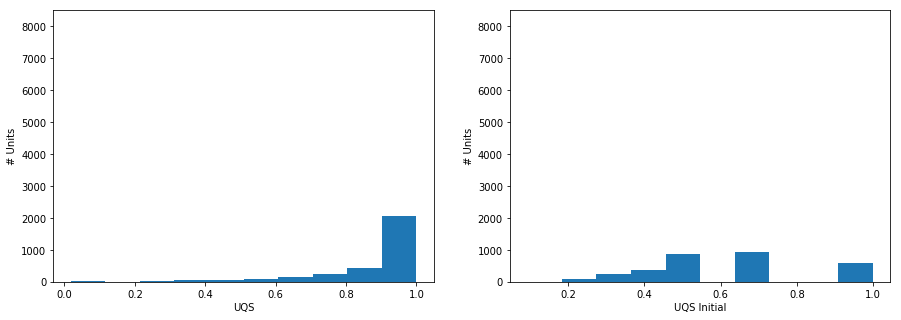

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(results_passages_per_article_random["units"]["uqs"])
plt.ylim(0, 8500)
plt.xlabel("UQS")
plt.ylabel("# Units")

plt.subplot(1, 2, 2)
plt.hist(results_passages_per_article_random["units"]["uqs_initial"])
plt.ylim(0, 8500)
plt.xlabel("UQS Initial")
plt.ylabel("# Units")

### Plot the change in the unit quality score (UQS) (beginning of the process - end of the process)

Text(0,0.5,u'Change in clarity')

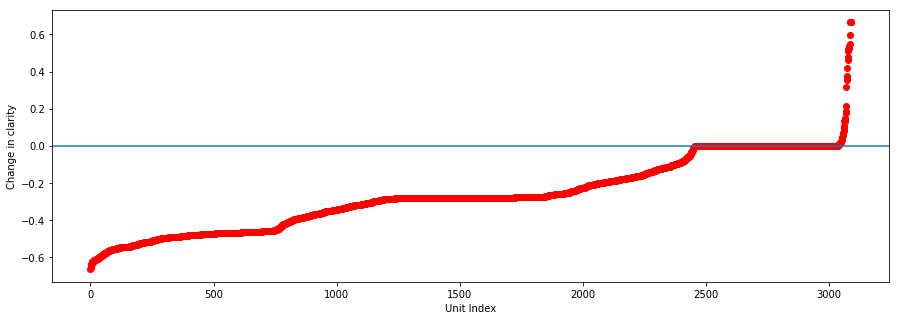

In [38]:
import numpy as np

difference = results_passages_per_article_random["units"]["uqs_initial"] - results_passages_per_article_random["units"]["uqs"]
difference = np.sort(difference)
plt.plot(np.arange(results_passages_per_article_random["units"].shape[0]), difference, 'ro')
plt.axhline(y=0)
plt.xlabel("Unit Index")
plt.ylabel("Change in clarity")

In [39]:
sortUQS = results_passages_per_article_random["units"].sort(['uqs'], ascending=[1])

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


Text(0.5,0,u'Sentence Index')

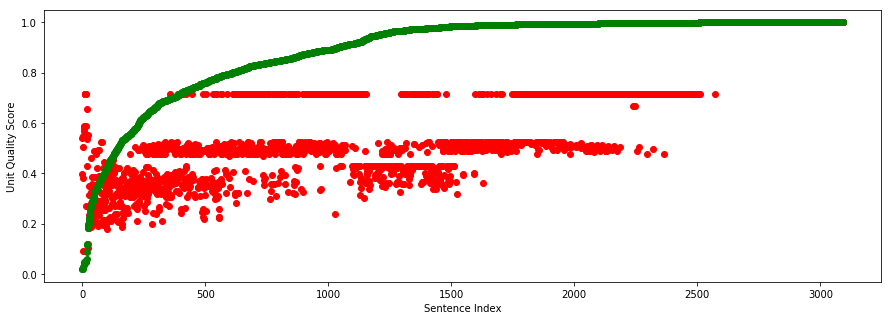

In [40]:
import numpy as np

plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Unit Quality Score')
plt.xlabel('Sentence Index')

### Plot the worker quality score (WQS) at the beginning of the process and at the end

#### Print the results for the workers in our dataset

In [41]:
results_passages_per_article_random["workers"].head(10)

,duration,output.relevant_snippets.count,job,judgment,unit,wqs,wqs_initial
worker,,,,,,,
1855113,521.000000,5.000000,1,5,5,0.002473,0.014519
1883056,197.333333,3.333333,1,18,18,0.158206,0.154025
1924522,44.893617,1.531915,1,94,94,0.481860,0.302648
3587109,46.848000,1.352000,1,125,125,0.539514,0.371113
3671372,86.294118,2.176471,1,17,17,0.309335,0.223926
4316379,69.549020,1.333333,1,102,102,0.530836,0.357101
6336109,301.000000,2.000000,1,1,1,0.002665,0.053362
6363996,271.000000,1.000000,1,1,1,0.061885,0.150791
6367365,86.620690,1.793103,1,29,29,0.243969,0.182978


Text(0,0.5,u'# Workers')

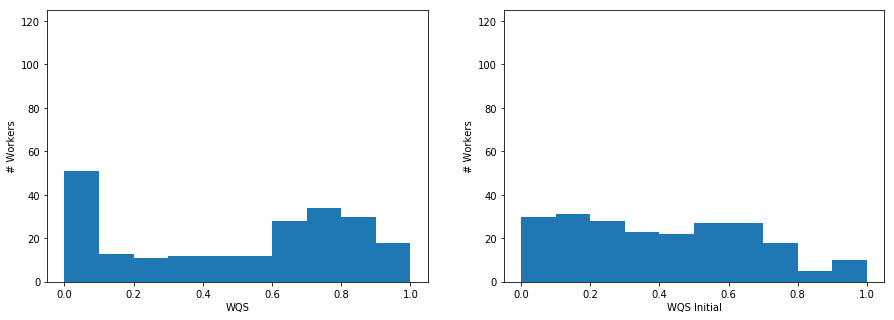

In [42]:
plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(results_passages_per_article_random["workers"]["wqs"])
plt.ylim(0, 125)
plt.xlabel("WQS")
plt.ylabel("# Workers")

plt.subplot(1, 2, 2)
plt.hist(results_passages_per_article_random["workers"]["wqs_initial"])
plt.ylim(0, 125)
plt.xlabel("WQS Initial")
plt.ylabel("# Workers")

### Plot the change in worker qualtity score at the beginning of the process and at the end

In [43]:
sortWQS = results_passages_per_article_random["workers"].sort(['wqs'], ascending=[1])

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


Text(0.5,0,u'Worker Index')

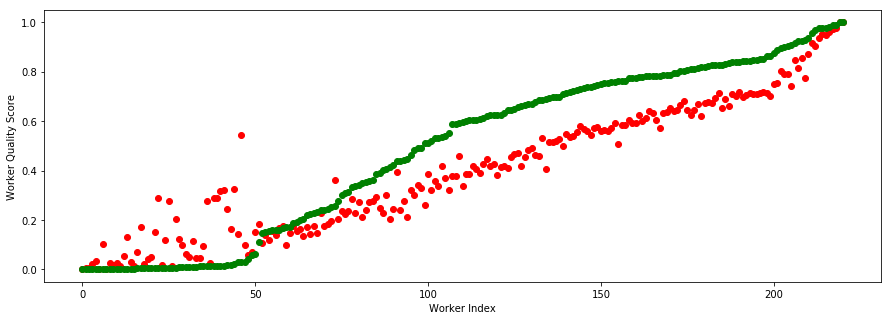

In [44]:
plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Worker Quality Score')
plt.xlabel('Worker Index')
#plt.legend(loc=9, bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size':12})

In [45]:
import numpy as np
import pandas as pd

results_passages_per_article_random["units"]['max_relevance_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random["units"])), index=results_passages_per_article_random["units"].index)
results_passages_per_article_random["units"]['none_score'] = pd.Series(np.random.randn(len(results_passages_per_article_random["units"])), index=results_passages_per_article_random["units"].index)

In [46]:
results_passages_per_article_random["units"].head(5)

,duration,input.bin,input.doc_len,input.document_body,input.document_id,input.document_title,input.index,input.query_id,input.topic_description,input.topic_query,job,output.relevant_snippets,output.relevant_snippets.annotations,output.relevant_snippets.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial,max_relevance_score,none_score
unit,,,,,,,,,,,,,,,,,,,,,
1522058937,107.000000,2,898,<p>LEAD: A wave of violent protest over region...,653,VIOLENCE IN INDIA REVIVES OLD FEARS,4250,422,What incidents have there been of stolen or fo...,"art, stolen, forged",Bin2-CFFiles/bin2_combinedfile_nist_only,"{u'none': 6, u's8': 1, u's7': 1, u's9': 1, u's...",10,5,7,0.888732,"{u'none': 0.950979430619, u's8': 0.04902056938...",0.714286,"{u'none': 0.857142857143, u's8': 0.14285714285...",0.937446,-0.890670
1522058940,67.428571,2,816,<p>LEAD: GEORGE P. SHULTZ leaves this week on ...,715,SHULTZ TO SEEK STRONGER TIES IN BLACK AFRICA,5133,443,What is the extent of U.S. (government and pri...,"U.S., investment, Africa",Bin2-CFFiles/bin2_combinedfile_nist_only,"{u'none': 5, u's8': 2, u's3': 2, u's2': 1, u's...",20,11,7,0.679697,"{u'none': 0.843065606174, u's8': 0.15693439382...",0.509862,"{u'none': 0.714285714286, u's8': 0.28571428571...",-0.890265,1.871180
1522058941,146.714286,2,571,<p>LEAD: WHEN Dan Woods was graduated from Neb...,1064,Factory-Guaranteed Teachers,7257,690,Find documents which describe an advantage in ...,college education advantage,Bin2-CFFiles/bin2_combinedfile_nist_only,"{u'none': 5, u's8': 2, u's3': 1, u's2': 2, u's...",19,9,7,0.812487,"{u'none': 0.915533740128, u's8': 0.08446625987...",0.517430,"{u'none': 0.714285714286, u's8': 0.28571428571...",-0.175994,-1.470491
1522058943,128.428571,2,961,<p>LEAD: George P. Shultz will leave Tuesday o...,1122,SHULTZ READY FOR TOUR OF 6 BLACK AFRICAN NATIONS,5103,443,What is the extent of U.S. (government and pri...,"U.S., investment, Africa",Bin2-CFFiles/bin2_combinedfile_nist_only,{u'none': 7},7,1,7,1.000000,{u'none': 1.0},1.000000,{u'none': 1.0},0.680141,0.794010
1522058944,155.571429,2,805,"<p>LEAD: As Congress returns to work, the word...",1341,Trade Doesn't Need Scapegoats,6955,414,How much sugar does Cuba export and which coun...,"Cuba, sugar, exports",Bin2-CFFiles/bin2_combinedfile_nist_only,{u'none': 7},7,1,7,1.000000,{u'none': 1.0},1.000000,{u'none': 1.0},1.909558,-0.317353


In [47]:
for i in xrange(0, len(results_passages_per_article_random["units"])):
    maxVal = 0
    found = False
    for key, value in results_passages_per_article_random["units"]["unit_annotation_score"].iloc[i].items():
        if key == "none":
            found = True
            results_passages_per_article_random["units"]['none_score'].iloc[i] = value
        else:
            if value > maxVal:
                maxVal = value
    results_passages_per_article_random["units"]['max_relevance_score'].iloc[i] = maxVal
    if found == False:
        results_passages_per_article_random["units"]['none_score'].iloc[i] = 0.0
        

In [48]:
results_passages_per_article_random["units"].to_csv("Bin2-CFFiles/bin2_results_nist_only.csv", index=False)

In [49]:
results_passages_per_article_random["units"]

,duration,input.bin,input.doc_len,input.document_body,input.document_id,input.document_title,input.index,input.query_id,input.topic_description,input.topic_query,job,output.relevant_snippets,output.relevant_snippets.annotations,output.relevant_snippets.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial,max_relevance_score,none_score
unit,,,,,,,,,,,,,,,,,,,,,
1522058937,107.000000,2,898,<p>LEAD: A wave of violent protest over region...,653,VIOLENCE IN INDIA REVIVES OLD FEARS,4250,422,What incidents have there been of stolen or fo...,"art, stolen, forged",Bin2-CFFiles/bin2_combinedfile_nist_only,"{u'none': 6, u's8': 1, u's7': 1, u's9': 1, u's...",10,5,7,0.888732,"{u'none': 0.950979430619, u's8': 0.04902056938...",0.714286,"{u'none': 0.857142857143, u's8': 0.14285714285...",0.049021,0.950979
1522058940,67.428571,2,816,<p>LEAD: GEORGE P. SHULTZ leaves this week on ...,715,SHULTZ TO SEEK STRONGER TIES IN BLACK AFRICA,5133,443,What is the extent of U.S. (government and pri...,"U.S., investment, Africa",Bin2-CFFiles/bin2_combinedfile_nist_only,"{u'none': 5, u's8': 2, u's3': 2, u's2': 1, u's...",20,11,7,0.679697,"{u'none': 0.843065606174, u's8': 0.15693439382...",0.509862,"{u'none': 0.714285714286, u's8': 0.28571428571...",0.156934,0.843066
1522058941,146.714286,2,571,<p>LEAD: WHEN Dan Woods was graduated from Neb...,1064,Factory-Guaranteed Teachers,7257,690,Find documents which describe an advantage in ...,college education advantage,Bin2-CFFiles/bin2_combinedfile_nist_only,"{u'none': 5, u's8': 2, u's3': 1, u's2': 2, u's...",19,9,7,0.812487,"{u'none': 0.915533740128, u's8': 0.08446625987...",0.517430,"{u'none': 0.714285714286, u's8': 0.28571428571...",0.084466,0.915534
1522058943,128.428571,2,961,<p>LEAD: George P. Shultz will leave Tuesday o...,1122,SHULTZ READY FOR TOUR OF 6 BLACK AFRICAN NATIONS,5103,443,What is the extent of U.S. (government and pri...,"U.S., investment, Africa",Bin2-CFFiles/bin2_combinedfile_nist_only,{u'none': 7},7,1,7,1.000000,{u'none': 1.0},1.000000,{u'none': 1.0},0.000000,1.000000
1522058944,155.571429,2,805,"<p>LEAD: As Congress returns to work, the word...",1341,Trade Doesn't Need Scapegoats,6955,414,How much sugar does Cuba export and which coun...,"Cuba, sugar, exports",Bin2-CFFiles/bin2_combinedfile_nist_only,{u'none': 7},7,1,7,1.000000,{u'none': 1.0},1.000000,{u'none': 1.0},0.000000,1.000000
1522058945,131.142857,2,825,"<p>LEAD: Jonathan Jay Pollard, the former Navy...",1599,U.S. DESCRIBES DATA THAT SPY PROVIDED ISRAEL,8839,389,"selling their products, formulas, etc. directl...",illegal technology transfer,Bin2-CFFiles/bin2_combinedfile_nist_only,"{u'none': 5, u's8': 2, u's13': 2, u's2': 1, u'...",33,16,7,0.826011,"{u'none': 0.92818597854, u's8': 0.07181402146,...",0.520408,"{u'none': 0.714285714286, u's8': 0.28571428571...",0.071814,0.928186
1522058949,156.142857,2,874,<p>LEAD: The engineer of a Conrail freight loc...,1931,CONFLICT OVER SIGNAL IN TRAIN INQUIRY,7109,436,What are the causes of railway accidents throu...,railway accidents,Bin2-CFFiles/bin2_combinedfile_nist_only,"{u's9': 2, u's8': 4, u's3': 4, u's12': 3, u's1...",40,13,7,0.455867,"{u's9': 0.0150568061056, u's8': 0.261173680124...",0.352301,"{u's9': 0.285714285714, u's8': 0.571428571429,...",0.261174,0.738826
1522058951,100.000000,2,755,<p>LEAD: Iran mounted a new offensive in the P...,2325,THOUSANDS REPORTEDLY KILLED,8560,330,This query is looking for examples of cooperat...,Iran-Iraq Cooperation,Bin2-CFFiles/bin2_combinedfile_nist_only,"{u'none': 5, u's8': 1, u's3': 1, u's2': 1, u's...",19,11,7,0.873486,"{u'none': 0.94527228553, u's8': 0.000748094232...",0.506307,"{u'none': 0.714285714286, u's8': 0.14285714285...",0.054728,0.945272
1522058952,167.285714,2,548,<p>LEAD: The baby boom generation now makes up...,2371,BABY BOOM GENERATION MAKES UP THIRD OF POPULAT...,12083,435,What measures have been taken worldwide and wh...,curbing population growth,Bin2-CFFiles/bin2_combinedfile_nist_only,{u'none

In [6]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("Bin2-CFFiles/bin2_results_nist_only.csv")
nist = pd.read_csv("nist_labels.csv")

dataset['nist_rel'] = pd.Series(np.random.randn(len(dataset)), index=dataset.index)
dataset['nist_rel_binary'] = pd.Series(np.random.randn(len(dataset)), index=dataset.index)

for i in xrange(len(dataset.index)):
    subset = nist[(nist["Topic Id"] == dataset["input.query_id"].iloc[i]) & (nist["Document Id"] == dataset["input.document_id"].iloc[i])]
    if len(subset) == 1:
        dataset['nist_rel'].iloc[i] = subset["Relevance"].iloc[0]
        
        if (subset["Relevance"].iloc[0] == 0):
            dataset['nist_rel_binary'].iloc[i] = 0
        else:
            dataset['nist_rel_binary'].iloc[i] = 1
        


In [7]:
dataset

,duration,input.bin,input.doc_len,input.document_body,input.document_id,input.document_title,input.index,input.query_id,input.topic_description,input.topic_query,...,output.relevant_snippets.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial,max_relevance_score,none_score,nist_rel,nist_rel_binary
0,107.000000,2,898,<p>LEAD: A wave of violent protest over region...,653,VIOLENCE IN INDIA REVIVES OLD FEARS,4250,422,What incidents have there been of stolen or fo...,"art, stolen, forged",...,5,7,0.888732,"Counter({'none': 0.9509794306186589, 's8': 0.0...",0.714286,"Counter({'none': 0.8571428571428571, 's8': 0.1...",0.049021,0.950979,0.0,0.0
1,67.428571,2,816,<p>LEAD: GEORGE P. SHULTZ leaves this week on ...,715,SHULTZ TO SEEK STRONGER TIES IN BLACK AFRICA,5133,443,What is the extent of U.S. (government and pri...,"U.S., investment, Africa",...,11,7,0.679697,"Counter({'none': 0.84306560617361, 's8': 0.156...",0.509862,"Counter({'none': 0.7142857142857143, 's8': 0.2...",0.156934,0.843066,1.0,1.0
2,146.714286,2,571,<p>LEAD: WHEN Dan Woods was graduated from Neb...,1064,Factory-Guaranteed Teachers,7257,690,Find documents which describe an advantage in ...,college education advantage,...,9,7,0.812487,"Counter({'none': 0.9155337401275273, 's8': 0.0...",0.517430,"Counter({'none': 0.7142857142857143, 's8': 0.2...",0.084466,0.915534,0.0,0.0
3,128.428571,2,961,<p>LEAD: George P. Shultz will leave Tuesday o...,1122,SHULTZ READY FOR TOUR OF 6 BLACK AFRICAN NATIONS,5103,443,What is the extent of U.S. (government and pri...,"U.S., investment, Africa",...,1,7,1.000000,Counter({'none': 1.0}),1.000000,Counter({'none': 1.0}),0.000000,1.000000,1.0,1.0
4,155.571429,2,805,"<p>LEAD: As Congress returns to work, the word...",1341,Trade Doesn't Need Scapegoats,6955,414,How much sugar does Cuba export and which coun...,"Cuba, sugar, exports",...,1,7,1.000000,Counter({'none': 1.0}),1.000000,Counter({'none': 1.0}),0.000000,1.000000,0.0,0.0
5,131.142857,2,825,"<p>LEAD: Jonathan Jay Pollard, the former Navy...",1599,U.S. DESCRIBES DATA THAT SPY PROVIDED ISRAEL,8839,389,"selling their products, formulas, etc. directl...",illegal technology transfer,...,16,7,0.826011,"Counter({'none': 0.9281859785400333, 's8': 0.0...",0.520408,"Counter({'none': 0.7142857142857143, 's8': 0.2...",0.071814,0.928186,0.0,0.0
6,156.142857,2,874,<p>LEAD: The engineer of a Conrail freight loc...,1931,CONFLICT OVER SIGNAL IN TRAIN INQUIRY,7109,436,What are the causes of railway accidents throu...,railway accidents,...,13,7,0.455867,"Counter({'none': 0.7388263198757741, 's8': 0.2...",0.352301,"Counter({'s8': 0.5714285714285714, 's3': 0.571...",0.261174,0.738826,1.0,1.0
7,100.000000,2,755,<p>LEAD: Iran mounted a new offensive in the P...,2325,THOUSANDS REPORTEDLY KILLED,8560,330,This query is looking for examples of cooperat...,Iran-Iraq Cooperation,...,11,7,0.873486,"Counter({'none': 0.9452722855300485, 's1': 0.0...",0.506307,"Counter({'none': 0.7142857142857143, 's1': 0.2...",0.054728,0.945272,0.0,0.0
8,167.285714,2,548,<p>LEAD: The baby boom generation now makes up...,2371,BABY BOOM GENERATION MAKES UP THIRD OF POPULAT...,12083,435,What measures have been taken worldwide and wh...,curbing population growth,...,1,7,1.000000,Counter({'none': 1.0}),1.000000,Counter({'none': 1.0}),0.000000,1.000000,0.0,0.0
9,97.714286,2,832,"<p>LEAD: A DECADE ago, the Federal Government ...",2534,RAIL AGENCY PICKS UP PIECES AFTER AMTRAK'S WOR...,7158,436,What are the causes of railway accidents throu...,railway accidents,...,7,7,0.855145,"Counter({'none': 0.9340904928942775, 's8': 0.0...",0.714286,"Counter({'none': 0.8571428571428571, 's8': 0.1...",0.065910,0.934090,1.0,1.0


In [71]:
dataset.to_csv("Bin2-CFFiles/bin2_results_nist_only.csv", index=False)

In [2]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("Bin2-CFFiles/bin2_results_nist_only.csv")

In [22]:
def compute_F1_score_relevant(dataset):
    nyt_f1 = np.zeros(shape=(100, 2))
    for idx in range(0, 100):
        thresh = (idx + 1) / 100.0
        tp = 0
        fp = 0
        tn = 0
        fn = 0

        for gt_idx in range(0, len(dataset.index)):
            #print(gt_idx)
            #print(dataset['relevance_score'].iloc[gt_idx])
            if dataset['max_relevance_score_norm'].iloc[gt_idx] >= thresh:
                if dataset["nist_rel_binary"].iloc[gt_idx] == 1:
                    tp = tp + 1.0
                else:
                    fp = fp + 1.0
            else:
                if dataset["nist_rel_binary"].iloc[gt_idx] == 1:
                    fn = fn + 1.0
                else:
                    tn = tn + 1.0

        nyt_f1[idx, 0] = thresh
        if tp != 0:
            nyt_f1[idx, 1] = 2.0 * tp / (2.0 * tp + fp + fn)
        else:
            nyt_f1[idx, 1] = 0
    return nyt_f1


def compute_F1_score_not_relevant(dataset):
    nyt_f1 = np.zeros(shape=(100, 2))
    for idx in range(0, 100):
        thresh = (idx + 1) / 100.0
        tp = 0
        fp = 0
        tn = 0
        fn = 0

        for gt_idx in range(0, len(dataset.index)):
            #print(gt_idx)
            #print(dataset['max_relevance_score'].iloc[gt_idx])
            if dataset['max_relevance_score_norm'].iloc[gt_idx] < thresh:
                if dataset["nist_rel_binary"].iloc[gt_idx] == 0:
                    tp = tp + 1.0
                else:
                    fp = fp + 1.0
            else:
                if dataset["nist_rel_binary"].iloc[gt_idx] == 0:
                    fn = fn + 1.0
                else:
                    tn = tn + 1.0

        nyt_f1[idx, 0] = thresh
        if tp != 0:
            nyt_f1[idx, 1] = 2.0 * tp / (2.0 * tp + fp + fn)
        else:
            nyt_f1[idx, 1] = 0
    return nyt_f1

In [6]:
notrel = compute_F1_score_not_relevant(dataset)
rel = compute_F1_score_relevant(dataset)

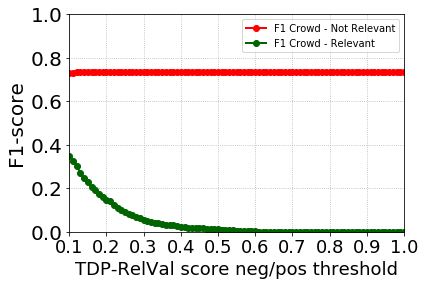

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 6, 4
plt.plot(notrel[:,0], notrel[:,1], 'bo-', color = 'red', lw = 2, label = "F1 Crowd - Not Relevant")
plt.plot(rel[:,0], rel[:,1], 'bo-', color = 'darkgreen', lw = 2, label = "F1 Crowd - Relevant")

plt.xlim(0.1,1.0)
plt.xlabel("TDP-RelVal score neg/pos threshold", fontsize=18)
plt.ylabel("F1-score", fontsize=20)
plt.ylim(0.0,1.0)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
leg = plt.legend()
leg.get_frame().set_alpha(0.8)
plt.grid(ls=':')
#plt.title("Without Highlight, Relations Not Merged, 3-point scale")
plt.savefig("Plots/bin2_all_topics.eps",  bbox_inches='tight', format="eps", dpi=1000)
plt.show()
plt.close()

In [8]:
rel

array([[ 0.01      ,  0.53482309],
       [ 0.02      ,  0.51315257],
       [ 0.03      ,  0.50576606],
       [ 0.04      ,  0.49509176],
       [ 0.05      ,  0.46820027],
       [ 0.06      ,  0.45070423],
       [ 0.07      ,  0.42864149],
       [ 0.08      ,  0.3899177 ],
       [ 0.09      ,  0.37174721],
       [ 0.1       ,  0.34950386],
       [ 0.11      ,  0.32671583],
       [ 0.12      ,  0.30373832],
       [ 0.13      ,  0.27173913],
       [ 0.14      ,  0.24721879],
       [ 0.15      ,  0.22896901],
       [ 0.16      ,  0.20542636],
       [ 0.17      ,  0.19451697],
       [ 0.18      ,  0.17443409],
       [ 0.19      ,  0.15935179],
       [ 0.2       ,  0.1473397 ],
       [ 0.21      ,  0.14039917],
       [ 0.22      ,  0.12534819],
       [ 0.23      ,  0.10860367],
       [ 0.24      ,  0.09822064],
       [ 0.25      ,  0.09292352],
       [ 0.26      ,  0.08201439],
       [ 0.27      ,  0.07647908],
       [ 0.28      ,  0.06961566],
       [ 0.29      ,

In [9]:
notrel

array([[ 0.01      ,  0.64324479],
       [ 0.02      ,  0.67617766],
       [ 0.03      ,  0.68068121],
       [ 0.04      ,  0.69216758],
       [ 0.05      ,  0.70294785],
       [ 0.06      ,  0.71153846],
       [ 0.07      ,  0.71907403],
       [ 0.08      ,  0.7204149 ],
       [ 0.09      ,  0.72507553],
       [ 0.1       ,  0.73010064],
       [ 0.11      ,  0.73163012],
       [ 0.12      ,  0.73357175],
       [ 0.13      ,  0.73377483],
       [ 0.14      ,  0.73336252],
       [ 0.15      ,  0.73528773],
       [ 0.16      ,  0.73479948],
       [ 0.17      ,  0.73485174],
       [ 0.18      ,  0.735269  ],
       [ 0.19      ,  0.73538789],
       [ 0.2       ,  0.73516949],
       [ 0.21      ,  0.73610818],
       [ 0.22      ,  0.73557895],
       [ 0.23      ,  0.73489933],
       [ 0.24      ,  0.73499268],
       [ 0.25      ,  0.73490704],
       [ 0.26      ,  0.73394495],
       [ 0.27      ,  0.73333333],
       [ 0.28      ,  0.73309757],
       [ 0.29      ,

In [10]:
dataset['crowd_rel_binary'] = pd.Series(np.random.randn(len(dataset)), index=dataset.index)

for i in xrange(len(dataset.index)):
    #subset = nist[(nist["Topic Id"] == dataset["input.query_id"].iloc[i]) & (nist["Document Id"] == dataset["input.document_id"].iloc[i])]
    if dataset['max_relevance_score'].iloc[i] >= 0.09:
        dataset['crowd_rel_binary'].iloc[i] = 1
    else:
        dataset['crowd_rel_binary'].iloc[i] = 0

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
dataset = pd.read_csv("Bin2-CFFiles/bin2_results_nist_only.csv")
print(max(dataset["max_relevance_score"]))
print(min(dataset["max_relevance_score"]))

0.605387473636
0.0


In [30]:
dataset

,duration,input.bin,input.doc_len,input.document_body,input.document_id,input.document_title,input.index,input.query_id,input.topic_description,input.topic_query,...,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial,max_relevance_score,none_score,nist_rel,nist_rel_binary,crowd_rel_binary,max_relevance_score_norm
0,107.000000,2,898,<p>LEAD: A wave of violent protest over region...,653,VIOLENCE IN INDIA REVIVES OLD FEARS,4250,422,What incidents have there been of stolen or fo...,"art, stolen, forged",...,0.888732,"Counter({'none': 0.9509794306186589, 's8': 0.0...",0.714286,"Counter({'none': 0.8571428571428571, 's8': 0.1...",0.049021,0.950979,0.0,0.0,0.0,0.080974
1,67.428571,2,816,<p>LEAD: GEORGE P. SHULTZ leaves this week on ...,715,SHULTZ TO SEEK STRONGER TIES IN BLACK AFRICA,5133,443,What is the extent of U.S. (government and pri...,"U.S., investment, Africa",...,0.679697,"Counter({'none': 0.84306560617361, 's8': 0.156...",0.509862,"Counter({'none': 0.7142857142857143, 's8': 0.2...",0.156934,0.843066,1.0,1.0,1.0,0.259230
2,146.714286,2,571,<p>LEAD: WHEN Dan Woods was graduated from Neb...,1064,Factory-Guaranteed Teachers,7257,690,Find documents which describe an advantage in ...,college education advantage,...,0.812487,"Counter({'none': 0.9155337401275273, 's8': 0.0...",0.517430,"Counter({'none': 0.7142857142857143, 's8': 0.2...",0.084466,0.915534,0.0,0.0,0.0,0.139524
3,128.428571,2,961,<p>LEAD: George P. Shultz will leave Tuesday o...,1122,SHULTZ READY FOR TOUR OF 6 BLACK AFRICAN NATIONS,5103,443,What is the extent of U.S. (government and pri...,"U.S., investment, Africa",...,1.000000,Counter({'none': 1.0}),1.000000,Counter({'none': 1.0}),0.000000,1.000000,1.0,1.0,0.0,0.000000
4,155.571429,2,805,"<p>LEAD: As Congress returns to work, the word...",1341,Trade Doesn't Need Scapegoats,6955,414,How much sugar does Cuba export and which coun...,"Cuba, sugar, exports",...,1.000000,Counter({'none': 1.0}),1.000000,Counter({'none': 1.0}),0.000000,1.000000,0.0,0.0,0.0,0.000000
5,131.142857,2,825,"<p>LEAD: Jonathan Jay Pollard, the former Navy...",1599,U.S. DESCRIBES DATA THAT SPY PROVIDED ISRAEL,8839,389,"selling their products, formulas, etc. directl...",illegal technology transfer,...,0.826011,"Counter({'none': 0.9281859785400333, 's8': 0.0...",0.520408,"Counter({'none': 0.7142857142857143, 's8': 0.2...",0.071814,0.928186,0.0,0.0,0.0,0.118625
6,156.142857,2,874,<p>LEAD: The engineer of a Conrail freight loc...,1931,CONFLICT OVER SIGNAL IN TRAIN INQUIRY,7109,436,What are the causes of railway accidents throu...,railway accidents,...,0.455867,"Counter({'none': 0.7388263198757741, 's8': 0.2...",0.352301,"Counter({'s8': 0.5714285714285714, 's3': 0.571...",0.261174,0.738826,1.0,1.0,1.0,0.431416
7,100.000000,2,755,<p>LEAD: Iran mounted a new offensive in the P...,2325,THOUSANDS REPORTEDLY KILLED,8560,330,This query is looking for examples of cooperat...,Iran-Iraq Cooperation,...,0.873486,"Counter({'none': 0.9452722855300485, 's1': 0.0...",0.506307,"Counter({'none': 0.7142857142857143, 's1': 0.2...",0.054728,0.945272,0.0,0.0,0.0,0.090401
8,167.285714,2,548,<p>LEAD: The baby boom generation now makes up...,2371,BABY BOOM GENERATION MAKES UP THIRD OF POPULAT...,12083,435,What measures have been taken worldwide and wh...,curbing population growth,...,1.000000,Counter({'none': 1.0}),1.000000,Counter({'none': 1.0}),0.000000,1.000000,0.0,0.0,0.0,0.000000
9,97.714286,2,832,"<p>LEAD: A DECADE ago, the Federal Government ...",2534,RAIL AGENCY PICKS UP PIECES AFTER AMTRAK'S WOR...,7158,436,What are the causes of railway accidents throu...,railway accidents,...,0.855145,"Counter({'none': 0.9340904928942775, 's8': 0.0...",0.714286,"Counter({'none': 0.8571428571428571, 's8': 0.1...",0.065910,0.934090,1.0,1.0,0.0,0.108872


In [64]:
def compute_F1_score_highly_relevant(dataset):
    nyt_f1 = np.zeros(shape=(100, 3))
    for idx in range(0, 100):
        thresh = (idx + 1) / 100.0
        tp = 0
        fp = 0
        tn = 0
        fn = 0

        for gt_idx in range(0, len(dataset.index)):
            #print(gt_idx)
            #print(dataset['max_relevance_score'].iloc[gt_idx])
            if dataset['max_relevance_score'].iloc[gt_idx] >= thresh:
                if dataset["nist_rel"].iloc[gt_idx] == 2:
                    tp = tp + 1.0

                else:
                    fp = fp + 1.0

            else:
                if dataset["nist_rel"].iloc[gt_idx] == 2:
                    fn = fn + 1.0

                else:
                    tn = tn + 1.0

        nyt_f1[idx, 0] = 1.0
        nyt_f1[idx, 1] = thresh
        if tp != 0:
            nyt_f1[idx, 2] = 2.0 * tp / (2.0 * tp + fp + fn)
        else:
            nyt_f1[idx, 2] = 0
    return nyt_f1

def compute_F1_score_not_relevant(dataset):
    nyt_f1 = np.zeros(shape=(100, 3))
    for idx in range(0, 100):
        thresh = (idx + 1) / 100.0
        tp = 0
        fp = 0
        tn = 0
        fn = 0

        for gt_idx in range(0, len(dataset.index)):
            #print(gt_idx)
            #print(dataset['max_relevance_score'].iloc[gt_idx])
            if dataset['max_relevance_score'].iloc[gt_idx] <= thresh:
                if dataset["nist_rel"].iloc[gt_idx] == 0:
                    tp = tp + 1.0

                else:
                    fp = fp + 1.0

            else:
                if dataset["nist_rel"].iloc[gt_idx] == 0:
                    fn = fn + 1.0

                else:
                    tn = tn + 1.0

        nyt_f1[idx, 0] = 0.0
        nyt_f1[idx, 1] = thresh
        if tp != 0:
            nyt_f1[idx, 2] = 2.0 * tp / (2.0 * tp + fp + fn)
        else:
            nyt_f1[idx, 2] = 0
    return nyt_f1

def compute_F1_score_relevant(dataset, nyt_f1):
    
    for idx in range(0, 5050):
        print(idx)
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        
        for gt_idx in range(0, len(dataset.index)):
            #print(gt_idx)
            #print(dataset['max_relevance_score'].iloc[gt_idx])
            if dataset['max_relevance_score'].iloc[gt_idx] > nyt_f1[idx, 0] and dataset['max_relevance_score'].iloc[gt_idx] < nyt_f1[idx, 1]:
                if dataset["nist_rel"].iloc[gt_idx] == 1:
                    tp = tp + 1.0

                else:
                    fp = fp + 1.0

            else:
                if dataset["nist_rel"].iloc[gt_idx] == 1:
                    fn = fn + 1.0

                else:
                    tn = tn + 1.0

        if tp != 0:
            nyt_f1[idx, 2] = 2.0 * tp / (2.0 * tp + fp + fn)
        else:
            nyt_f1[idx, 2] = 0
    return nyt_f1

idx = 0
nyt_f1 = np.zeros(shape=(5050, 3))
for idx1 in range(0, 100):
    thresh1 = (idx1) / 100.0
    for idx2 in range(idx1, 100):
        thresh2 = (idx2 + 1) /100.0
        nyt_f1[idx, 0] = thresh1
        nyt_f1[idx, 1] = thresh2
        nyt_f1[idx, 2] = 0.0
        idx = idx + 1

In [65]:
highlyrel = compute_F1_score_highly_relevant(dataset)
notrel = compute_F1_score_not_relevant(dataset)
rel = compute_F1_score_relevant(dataset, nyt_f1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


In [66]:
highlyrel

array([[ 1.        ,  0.01      ,  0.31296101],
       [ 1.        ,  0.02      ,  0.30760095],
       [ 1.        ,  0.03      ,  0.3071298 ],
       [ 1.        ,  0.04      ,  0.30719794],
       [ 1.        ,  0.05      ,  0.2979021 ],
       [ 1.        ,  0.06      ,  0.29337305],
       [ 1.        ,  0.07      ,  0.29073482],
       [ 1.        ,  0.08      ,  0.27830596],
       [ 1.        ,  0.09      ,  0.27554745],
       [ 1.        ,  0.1       ,  0.26484907],
       [ 1.        ,  0.11      ,  0.25819672],
       [ 1.        ,  0.12      ,  0.25081081],
       [ 1.        ,  0.13      ,  0.24626007],
       [ 1.        ,  0.14      ,  0.23826715],
       [ 1.        ,  0.15      ,  0.23677582],
       [ 1.        ,  0.16      ,  0.22864652],
       [ 1.        ,  0.17      ,  0.22013423],
       [ 1.        ,  0.18      ,  0.20699301],
       [ 1.        ,  0.19      ,  0.19884726],
       [ 1.        ,  0.2       ,  0.17673049],
       [ 1.        ,  0.21      ,  0.174

In [67]:
rel

array([[ 0.        ,  0.01      ,  0.25809822],
       [ 0.        ,  0.02      ,  0.27537594],
       [ 0.        ,  0.03      ,  0.28189774],
       [ 0.        ,  0.04      ,  0.28989362],
       [ 0.        ,  0.05      ,  0.30394626],
       [ 0.        ,  0.06      ,  0.31186715],
       [ 0.        ,  0.07      ,  0.32265625],
       [ 0.        ,  0.08      ,  0.33898305],
       [ 0.        ,  0.09      ,  0.34536082],
       [ 0.        ,  0.1       ,  0.3497307 ],
       [ 0.        ,  0.11      ,  0.35684062],
       [ 0.        ,  0.12      ,  0.36300658],
       [ 0.        ,  0.13      ,  0.37376826],
       [ 0.        ,  0.14      ,  0.38040926],
       [ 0.        ,  0.15      ,  0.38502319],
       [ 0.        ,  0.16      ,  0.39069158],
       [ 0.        ,  0.17      ,  0.39191392],
       [ 0.        ,  0.18      ,  0.3945754 ],
       [ 0.        ,  0.19      ,  0.39704939],
       [ 0.        ,  0.2       ,  0.39578679],
       [ 0.        ,  0.21      ,  0.396

In [68]:
notrel

array([[ 0.        ,  0.01      ,  0.64324479],
       [ 0.        ,  0.02      ,  0.67617766],
       [ 0.        ,  0.03      ,  0.68068121],
       [ 0.        ,  0.04      ,  0.69216758],
       [ 0.        ,  0.05      ,  0.70294785],
       [ 0.        ,  0.06      ,  0.71153846],
       [ 0.        ,  0.07      ,  0.71907403],
       [ 0.        ,  0.08      ,  0.7204149 ],
       [ 0.        ,  0.09      ,  0.72507553],
       [ 0.        ,  0.1       ,  0.73010064],
       [ 0.        ,  0.11      ,  0.73163012],
       [ 0.        ,  0.12      ,  0.73357175],
       [ 0.        ,  0.13      ,  0.73377483],
       [ 0.        ,  0.14      ,  0.73336252],
       [ 0.        ,  0.15      ,  0.73528773],
       [ 0.        ,  0.16      ,  0.73479948],
       [ 0.        ,  0.17      ,  0.73485174],
       [ 0.        ,  0.18      ,  0.735269  ],
       [ 0.        ,  0.19      ,  0.73538789],
       [ 0.        ,  0.2       ,  0.73516949],
       [ 0.        ,  0.21      ,  0.736

In [53]:
idx = 0
nyt_f1 = np.zeros(shape=(5050, 3))
for idx1 in range(0, 100):
    thresh1 = (idx1) / 100.0
    for idx2 in range(idx1, 100):
        thresh2 = (idx2 + 1) /100.0
        nyt_f1[idx, 0] = thresh1
        nyt_f1[idx, 1] = thresh2
        nyt_f1[idx, 2] = 0.0
        idx = idx + 1
        
        
for idx in range(0, 5050):
    print(idx)
    tp = 0
    fp = 0
    tn = 0
    fn = 0
        
    for gt_idx in range(0, len(dataset.index)):
        if dataset['max_relevance_score'].iloc[gt_idx] > nyt_f1[idx, 0] and dataset['max_relevance_score'].iloc[gt_idx] < nyt_f1[idx, 1]:                
            if dataset["nist_rel"].iloc[gt_idx] == 1:
                tp = tp + 1.0
            else:
                fp = fp + 1.0
        else:
            if dataset["nist_rel"].iloc[gt_idx] == 1:
                fn = fn + 1.0
            else:
                tn = tn + 1.0
        
        if dataset['max_relevance_score'].iloc[gt_idx] >= nyt_f1[idx, 1]:
            if dataset["nist_rel"].iloc[gt_idx] == 2:
                tp = tp + 1.0
            else:
                fp = fp + 1.0
        else:
            if dataset["nist_rel"].iloc[gt_idx] == 2:
                fn = fn + 1.0
            else:
                tn = tn + 1.0
        
        if dataset['max_relevance_score'].iloc[gt_idx] <= nyt_f1[idx, 0]:
            if dataset["nist_rel"].iloc[gt_idx] == 0:
                tp = tp + 1.0
            else:
                fp = fp + 1.0
        else:
            if dataset["nist_rel"].iloc[gt_idx] == 0:
                fn = fn + 1.0
            else:
                tn = tn + 1.0

        
    if tp != 0:
        nyt_f1[idx, 2] = 2.0 * tp / (2.0 * tp + fp + fn)
    else:
        nyt_f1[idx, 2] = 0


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


In [59]:
nyt_f1

array([[ 0.        ,  0.01      ,  0.3052053 ],
       [ 0.        ,  0.02      ,  0.30779179],
       [ 0.        ,  0.03      ,  0.30973165],
       [ 0.        ,  0.04      ,  0.31231814],
       [ 0.        ,  0.05      ,  0.31522793],
       [ 0.        ,  0.06      ,  0.31749111],
       [ 0.        ,  0.07      ,  0.32169415],
       [ 0.        ,  0.08      ,  0.32686712],
       [ 0.        ,  0.09      ,  0.32977692],
       [ 0.        ,  0.1       ,  0.33074685],
       [ 0.        ,  0.11      ,  0.33365664],
       [ 0.        ,  0.12      ,  0.33624313],
       [ 0.        ,  0.13      ,  0.34173941],
       [ 0.        ,  0.14      ,  0.34464921],
       [ 0.        ,  0.15      ,  0.347559  ],
       [ 0.        ,  0.16      ,  0.35014549],
       [ 0.        ,  0.17      ,  0.35014549],
       [ 0.        ,  0.18      ,  0.35079211],
       [ 0.        ,  0.19      ,  0.35176204],
       [ 0.        ,  0.2       ,  0.34917556],
       [ 0.        ,  0.21      ,  0.349

In [58]:
import numpy as np
np.set_printoptions(threshold=np.nan)

In [70]:
#0.09, 0.19

dataset['crowd_rel_ternary'] = pd.Series(np.random.randn(len(dataset)), index=dataset.index)

for i in xrange(len(dataset.index)):
    if dataset['max_relevance_score'].iloc[i] <= 0.09:
        dataset['crowd_rel_ternary'].iloc[i] = 0
    elif dataset['max_relevance_score'].iloc[i] >= 0.19:
        dataset['crowd_rel_ternary'].iloc[i] = 2
    else:
        dataset['crowd_rel_ternary'].iloc[i] = 1